# QSCOUT Optimizations with Qiskit

Below is a brief tutorial on Superstaq optimizations for QSCOUT using Qiskit. For more information on QSCOUT, visit their website [here](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout/). For those who'd like to follow along, you can try the code out on our [Jupyter Hub](https://tinyurl.com/2p9dtyxj).

## Imports and API Token

For this tutorial, we will just need the imports listed below to run the Superstaq optimizations. If you do not have `qiskit-superstaq` installed on your machine, you can follow the guide [here](https://docs-superstaq.readthedocs.io/en/latest/get_started/installation.html#installing-qiskit-superstaq) to set it up and its dependencies. 

In [1]:
# Required imports
import numpy as np
import qiskit
import qiskit_superstaq as qss

# Optional imports
import os  # used if setting a token as an environment variable

To interface Superstaq via Qiskit, we first instantiate a provider in `qiskit-superstaq` with `SuperstaQProvider()`. We then supply a Superstaq API token (or key) by either providing our API token as an argument of `qss.SuperstaQProvider()` or by setting it as an environment variable (see more details [here](https://docs-superstaq.readthedocs.io/en/latest/get_started/basics.html#Set-up-access-to-SuperstaQ%E2%80%99s-API))

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
provider = qss.SuperstaQProvider()

# Display credit balance
print("Current user balance is", provider.get_balance())

Current user balance is $262.30


## SIngle Circuit Compilation

Let us start by creating an example qiskit circuit that we will then compile and optimize for the QSCOUT trapped-ion testbed at Sandia National Laboratories (learn more [here](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout/)).

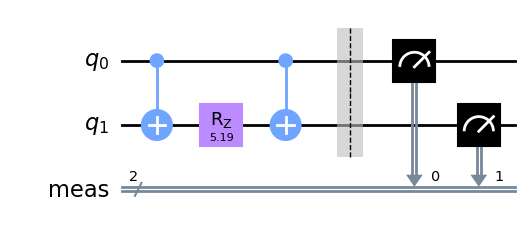

In [3]:
# Create a two-qubit qiskit circuit
theta = np.random.uniform(0, 4 * np.pi)
circuit1 = qiskit.QuantumCircuit(2)
circuit1.cx(0, 1)
circuit1.rz(theta, 1)
circuit1.cx(0, 1)
circuit1.measure_all()

# Draw circuit for visualization
circuit1.draw(output="mpl")

Using the same circuit from above as input, we will now compile it for QSCOUT and visualize the differences by drawing the compiled circuit. 

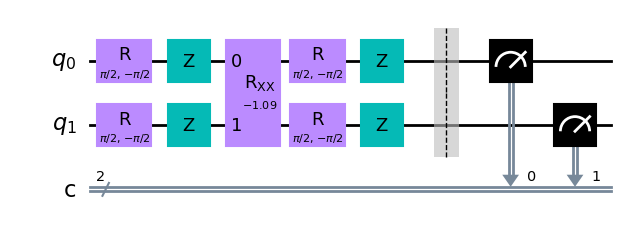

In [4]:
# Compile with qscout compile
compiler_output = provider.qscout_compile(circuit1)

# Call circuit from the compiler output to get the corresponding output circuit
output_circuit = compiler_output.circuit

# Visualize the compiled circuit
output_circuit.draw("mpl")

The resulting output is now a circuit compiled to QSCOUT's native operations. And with Superstaq compilation, you can also get the corresponding Jaqal (see [Just another quantum assembly language](https://arxiv.org/abs/2008.08042)) program for the compiled circuit by running the following:

In [5]:
# Get jaqal program
print(compiler_output.jaqal_program)

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
MS allqubits[0] allqubits[1] 0 -1.0948536304627763
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
measure_all



## Multiple Circuits Compilation

All the functionalities we have seen so far can also be used on a multiple circuits input as well. To illustrate this, lets create a different, example two-qubit circuit (say, a Bell-state circuit):

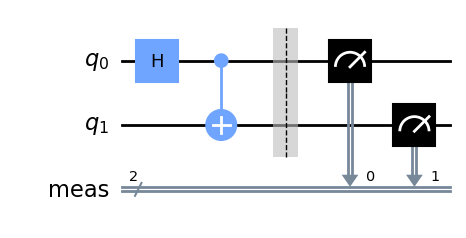

In [6]:
# Create second circuit
circuit2 = qiskit.QuantumCircuit(2)
circuit2.h(0)
circuit2.cx(0, 1)
circuit2.measure_all()

# Draw second circuit for visualization
circuit2.draw("mpl")

By passing multiple circuits as a list to the `qscout_compile` endpoint, we can compile all of them individually with a single call to `qscout_compile` and get all the corresponding compiled circuits and Jaqal programs back as a list, like so:  

In [7]:
# Create list of circuits
circuit_list = [circuit1, circuit2]

# Compile a list of circuits and their respective jaqal programs
compiler_output_list = provider.qscout_compile(circuit_list)
jaqal_output_list = compiler_output_list.jaqal_programs

Compiled circuit 1 

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
MS allqubits[0] allqubits[1] 0 -1.0948536304627763
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
measure_all



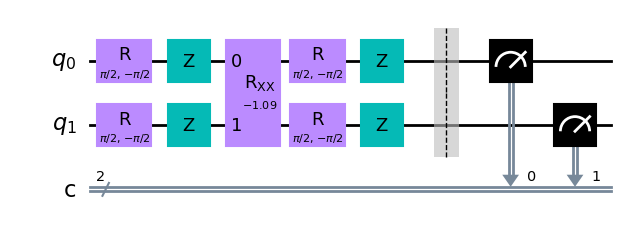

In [8]:
# To get the list of compiled output circuits from the compiler output list, call `circuits` instead of just `circuit` that is called for a single circuit input
output_circuits = compiler_output_list.circuits

# Visualize and get the jaqal program of the first compiled circuit
print("Compiled circuit 1 \n")
print(jaqal_output_list[0])
output_circuits[0].draw("mpl")

Compiled circuit 2 

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] 3.141592653589793 3.141592653589793
	R allqubits[1] 3.141592653589793 3.141592653589793
>
MS allqubits[0] allqubits[1] 0 -1.5707963267948966
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] 3.141592653589793 1.5707963267948966
>
Rz allqubits[0] 1.5707963267948966
measure_all



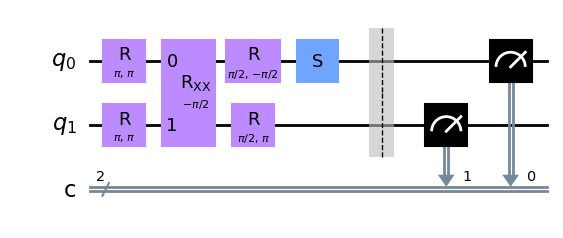

In [9]:
# Visualize and get the jaqal program of second compiled circuit
print("Compiled circuit 2 \n")
print(jaqal_output_list[1])
output_circuits[1].draw("mpl")

## Entangling Basis Compilation

When compiling to the QSCOUT gateset, we can also specify the type of entangling basis gate to utilize during the compilation -- either a $XX$ or $ZZ$. Lets consider the first circuit example for earlier but with a different, random $R_Z$ angle and single measurement,

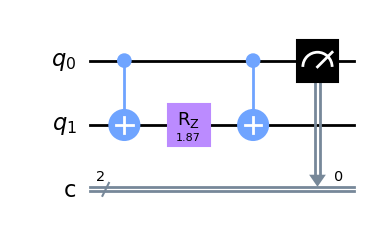

In [10]:
# Create circuit
theta = np.random.uniform(0, np.pi)
circuit = qiskit.QuantumCircuit(2, 2)
circuit.cx(0, 1)
circuit.rz(theta, 1)
circuit.cx(0, 1)
circuit.measure(0, 0)

# Visualize circuit
circuit.draw(output="mpl")

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
<
	Rz allqubits[0] -3.141592653589793
	Rz allqubits[1] -3.141592653589793
>
MS allqubits[0] allqubits[1] 0 -1.2754083356768138
<
	R allqubits[0] -1.5707963267948966 1.5707963267948966
	R allqubits[1] -1.5707963267948966 1.5707963267948966
>
measure_all



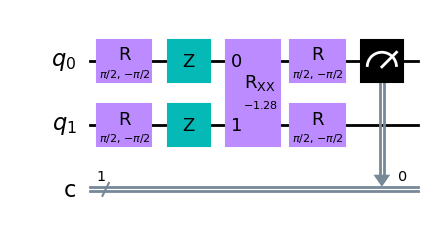

In [11]:
# Compile with XX entangling basis
compiler_output = provider.qscout_compile(circuit, base_entangling_gate="xx")

# Visualize and get jaqal program of the compiled circuit
print(compiler_output.jaqal_program)
compiler_output.circuit.draw(output="mpl")

As we can see above, we get the same compiled gate structure as before. This is because, by default, the $XX$ interaction is used, and we observe that it uses the $R_{XX}$ gate as the base entangling gate in the compiled circuit. Similarly, lets take a look at the compiled circuit if we now specify the compiler to use the $ZZ$ interaction instead:

from qscout.v1.std usepulses *

register allqubits[2]

prepare_all
ZZ allqubits[0] allqubits[1] -1.2754083356768138
Rz allqubits[1] -3.141592653589792
measure_all



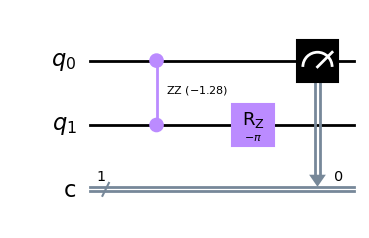

In [12]:
# Compile with zz entangling basis
compiler_output = provider.qscout_compile(circuit, base_entangling_gate="zz")

# Get jaqal program and draw circuit
print(compiler_output.jaqal_program)
compiler_output.circuit.draw(output="mpl")

Looking at the compiled circuit above, we can see that by specifying the $ZZ$ entangling basis, we use $R_{ZZ}$ gate as the base entangling gate and the remaining single-qubit gates are compiled and optimized accordingly. 

## Swap Mirroring

In addition to specifying the type of base entangling gate to use for the compilation and optimization, we can also specify whether to use mirror swapping to help reduce the two-qubit gate overhead of the circuit. By default, it is not enabled; but we will see the differences in circuit compilation by compiling a random quantum volume model circuit. 

### Create random Quantum Volume (QV) circuit

In [13]:
# Generate a random QV circuit
circ = qiskit.circuit.library.QuantumVolume(num_qubits=2, depth=2, seed=123)
circ.measure_all()

### Compile without swap mirroring

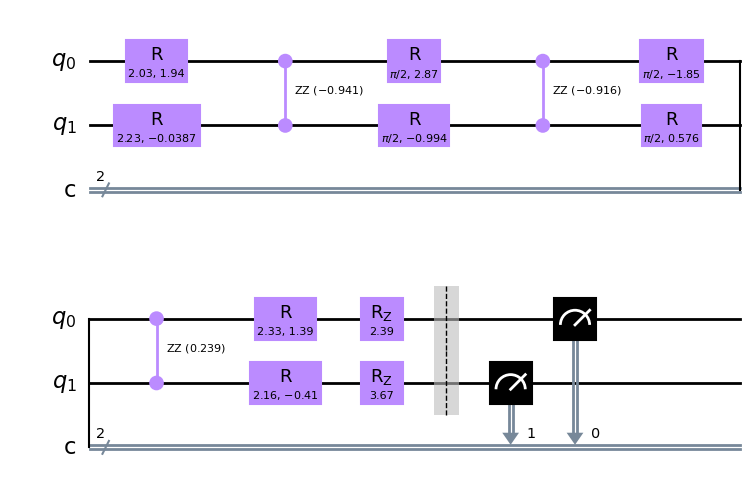

In [14]:
# Compile with no swap mirroring
output_nsm = provider.qscout_compile(circ, mirror_swaps=False, base_entangling_gate="zz")

# Visualize the circuit
circ_nsm = output_nsm.circuit
circ_nsm.draw("mpl", fold=10)

### Compile with swap mirroring

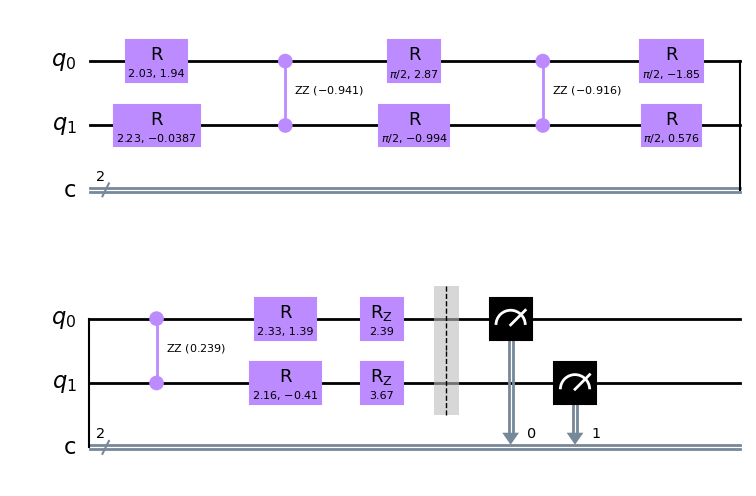

In [15]:
# Compile with swap mirroring
output_wsm = provider.qscout_compile(circ, mirror_swaps=True, base_entangling_gate="zz")

# Visualize the circuit
circ_wsm = output_wsm.circuit
circ_wsm.draw("mpl", fold=10)

### Return final logical to physical qubit mapping

In [16]:
# Return final qubit map for non swap-mirrored circuit
map_nsm = output_nsm.final_logical_to_physical
print("Non swap-mirrored mapping:", map_nsm)

# Return final qubit map for swap-mirrored circuit
map_wsm = output_wsm.final_logical_to_physical
print("Swap-mirrored mapping:", map_wsm)

Non swap-mirrored mapping: {0: 0, 1: 1}
Swap-mirrored mapping: {0: 0, 1: 1}


## Using Superstaq Simulator

Lastly, we will go over how to submit a circuit to a backend and simulate it. This feature is available to free trial users, and can be done by passing the `"dry-run"` method parameter when calling `run()` to instruct Superstaq to simulate the circuit. 

In [17]:
# Example Bell state circuit
qc = qiskit.QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure(0, 0)
qc.measure(1, 1)

# Get qscout backend from provider
backend = provider.get_backend("sandia_qscout_qpu")

job = backend.run(
    qc, shots=100, method="dry-run"
)  # specify "dry-run" as the method to run Superstaq simulation

# Get the counts from the measurement
print(job.result().get_counts())

{'00': 49, '11': 51}
